### 16.2.2 数据预处理

### 导入需要的库

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 导入数据

In [2]:
# 指定数据存放路径
data_dir = Path("ocr_data")

# 获取所有验证码图像，并以列表方式存放
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# 对训练和验证数据，设置批数量大小
batch_size = 16

# 设置图像大小
img_width = 200
img_height = 50

downsample_factor = 4

max_length = max([len(label) for label in labels])

Number of images found:  2998
Number of labels found:  2998
Number of unique characters:  18
Characters present:  {'9', '2', '4', 'y', 'j', '3', '8', 'a', 'd', 'q', 's', '5', '7', '6', 'h', 'k', 't', '1'}


## 预处理数据

In [3]:
# 把字符转换为整数
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# 把整数对应原来的字符
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. 获取数据大小
    size = len(images)
    # 2. 索引化并打乱数据
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. 获取训练数据大小
    train_samples = int(size * train_size)
    # 4. 把数据划分为训练和验证数据
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# 把数据划分为训练和验证数据
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. 读图像
    img = tf.io.read_file(img_path)
    # 2. 把图像转换为灰色
    img = tf.io.decode_png(img, channels=1)
    # 3.转换数据类型
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. 改变数据形状
    img = tf.image.resize(img, [img_height, img_width])
    # 5. 改变数据的维度次序
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. 把标签字符对应到数字
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. 返回一个字典，包含图像及标签
    return {"image": img, "label": label}

## 创建数据对象

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## 可视化数据

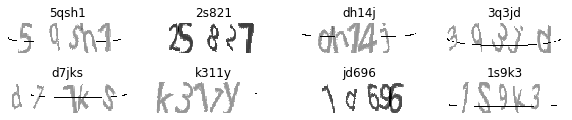

In [5]:
_, ax = plt.subplots(2, 4, figsize=(10, 2))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(8):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

### 16.2.3 构建模型

In [6]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()    
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

### 16.2.4训练模型

In [7]:
epochs = 200
early_stopping_patience = 100
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/200
169/169 [==============================] - 21s 61ms/step - loss: 22.0665 - val_loss: 16.1782
Epoch 2/200
169/169 [==============================] - 7s 39ms/step - loss: 16.1598 - val_loss: 16.1217
Epoch 3/200
169/169 [==============================] - 7s 41ms/step - loss: 16.1123 - val_loss: 15.9856
Epoch 4/200
169/169 [==============================] - 7s 40ms/step - loss: 15.9437 - val_loss: 15.9323
Epoch 5/200
169/169 [==============================] - 7s 40ms/step - loss: 15.7855 - val_loss: 15.8825
Epoch 6/200
169/169 [==============================] - 7s 40ms/step - loss: 15.7354 - val_loss: 15.8056
Epoch 7/200
169/169 [==============================] - 7s 40ms/step - loss: 15.7094 - val_loss: 15.7644
Epoch 8/200
169/169 [==============================] - 7s 41ms/step - loss: 15.6952 - val_loss: 15.7467
Epoch 9/200
169/169 [==============================] - 7s 40ms/step - loss: 15.6631 - val_loss: 15.7235
Epoch 10/200
169/169 [==============================] - 7s 40ms

Epoch 80/200
169/169 [==============================] - 7s 40ms/step - loss: 0.1152 - val_loss: 0.1580
Epoch 81/200
169/169 [==============================] - 7s 41ms/step - loss: 0.1475 - val_loss: 0.1225
Epoch 82/200
169/169 [==============================] - 7s 40ms/step - loss: 0.1201 - val_loss: 0.0769
Epoch 83/200
169/169 [==============================] - 7s 40ms/step - loss: 0.1182 - val_loss: 0.0830
Epoch 84/200
169/169 [==============================] - 7s 41ms/step - loss: 0.1110 - val_loss: 0.0706
Epoch 85/200
169/169 [==============================] - 7s 41ms/step - loss: 0.1002 - val_loss: 0.0646
Epoch 86/200
169/169 [==============================] - 7s 41ms/step - loss: 0.1400 - val_loss: 0.1148
Epoch 87/200
169/169 [==============================] - 7s 40ms/step - loss: 0.1129 - val_loss: 0.0900
Epoch 88/200
169/169 [==============================] - 7s 40ms/step - loss: 0.1672 - val_loss: 0.0630
Epoch 89/200
169/169 [==============================] - 7s 41ms/step - lo

Epoch 159/200
169/169 [==============================] - 7s 39ms/step - loss: 0.1630 - val_loss: 0.0656
Epoch 160/200
169/169 [==============================] - 7s 39ms/step - loss: 0.0986 - val_loss: 0.0579
Epoch 161/200
169/169 [==============================] - 7s 39ms/step - loss: 0.0596 - val_loss: 0.0391
Epoch 162/200
169/169 [==============================] - 7s 40ms/step - loss: 0.0391 - val_loss: 0.0604
Epoch 163/200
169/169 [==============================] - 7s 40ms/step - loss: 0.0519 - val_loss: 0.0503
Epoch 164/200
169/169 [==============================] - 7s 39ms/step - loss: 0.0378 - val_loss: 0.0698
Epoch 165/200
169/169 [==============================] - 7s 40ms/step - loss: 0.0474 - val_loss: 0.0146
Epoch 166/200
169/169 [==============================] - 7s 41ms/step - loss: 0.0444 - val_loss: 0.0523
Epoch 167/200
169/169 [==============================] - 7s 40ms/step - loss: 0.0396 - val_loss: 0.0423
Epoch 168/200
169/169 [==============================] - 7s 40ms


## 进行识别

当我们训练好一个RNN模型时，给定一个输入序列X，我们需要找到最可能的输出，也就是求解
$$ Y^*=\underset{k}{argmax} P(Y/X)$$
求解最可能的输出有两种方案，一种是Greedy Search，第二种是beam search
Greedy Search:每个时间片均取该时间片概率最高的节点作为输出
beam search:Beam Search是寻找全局最优值和Greedy Search在查找时间和模型精度的一个折中。一个简单的beam search在每个时间片计算所有可能假设的概率，并从中选出最高的几个作为一组。然后再从这组假设的基础上产生概率最高的几个作为一组假设，依次进行，直到达到最后一个时间片。

In [9]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            4921

## 可视化识别结果

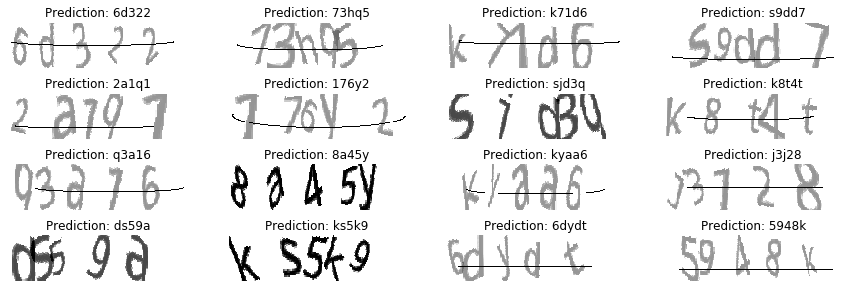

In [10]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

<center>图16-2 原文本内容与预测结果  </center>
从识别结果来看，精度接近100%。